<a href="https://colab.research.google.com/github/josephum/ai-adventure/blob/main/CapitalClassifySound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

--2020-11-14 13:30:53--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 74.125.195.102, 74.125.195.100, 74.125.195.101, ...
Connecting to goo.gl (goo.gl)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2020-11-14 13:30:53--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER               29%[====>               ]   1.65G  18.9MB/s    eta 5m 56s 

In [ ]:
!pwd
!ls
!ls UrbanSound8K/
!ls sample_data/

/content
sample_data
ls: cannot access 'UrbanSound8K/': No such file or directory
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
import IPython
IPython.display.Audio("UrbanSound8K/audio/fold1/26270-9-0-32.wav")

In [ ]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [ ]:
!mkdir 'UrbanSound8K/spectrogram'


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
from pathlib import Path
import librosa.display
import os
def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [ ]:
for i in range(1, 11):
    create_fold_spectrograms(str(i))

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Processing fold 10


In [ ]:
!ls /content/sample_data/


anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
!mkdir 'UrbanSound8K/data'

mkdir: cannot create directory ‘UrbanSound8K/data’: File exists


In [ ]:

import os
import glob
import shutil
from pathlib import Path  
data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')  
def create_fold_directory(fold):
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name)

In [ ]:
for i in range(1, 11):
    create_fold_directory(str(i))

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [ ]:
data_directory = Path('UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4043 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
gun_shot,gun_shot,gun_shot,gun_shot,gun_shot
Path: UrbanSound8K/data/1;

Valid: LabelList (873 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
gun_shot,gun_shot,gun_shot,gun_shot,gun_shot
Path: UrbanSound8K/data/1;

Test: None

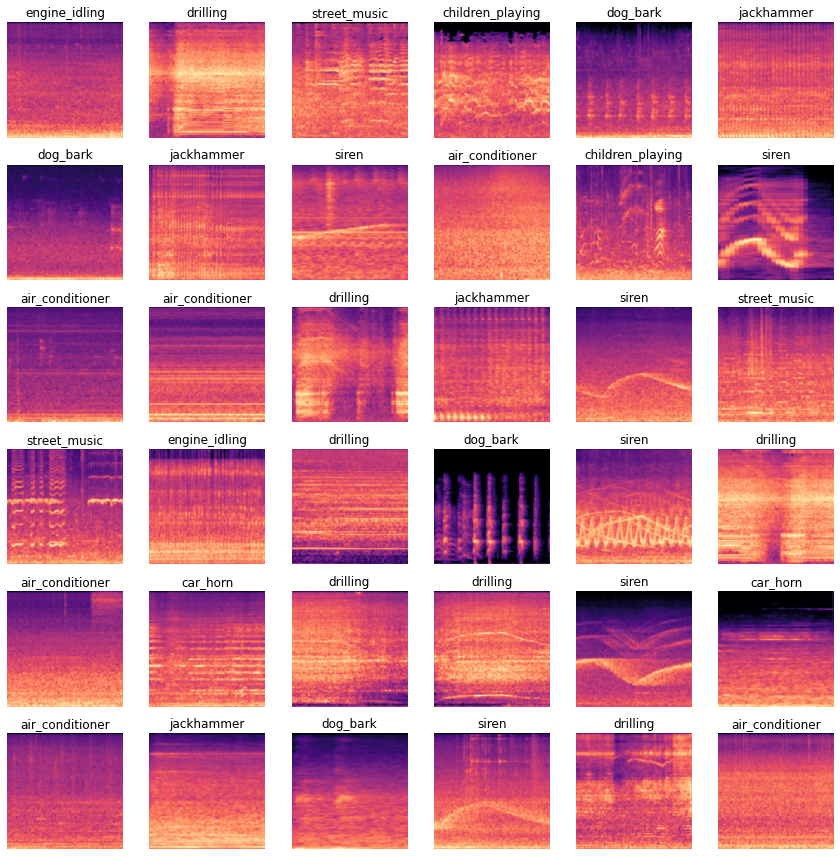

In [ ]:

data.show_batch(rows=6, figsize=(12,12))

In [ ]:

def process_fold(fold):
    data_directory = Path('UrbanSound8K/data')
    data = ImageDataBunch.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = create_cnn(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
process_fold('1')


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.613202,1.031543,0.320733,00:32
1,0.869922,0.899504,0.270332,00:30
2,0.537489,0.901242,0.287514,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.559619,0.914762,0.247423,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.228424,0.833465,0.241695,00:32
1,0.166640,0.767203,0.225659,00:32
2,0.129503,0.771416,0.227950,00:32


In [ ]:
!pwd

/content


In [ ]:
process_fold('2')


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,time
0,1.604280,1.571817,0.421171,00:33
1,0.835025,1.317114,0.390766,00:30
2,0.519945,1.305385,0.387387,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.561795,1.502213,0.346847,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.252014,1.324921,0.331081,00:32
1,0.192225,1.239162,0.318694,00:32
2,0.149041,1.236921,0.322072,00:32


In [ ]:
process_fold('3')


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,time
0,1.546210,1.439376,0.407568,00:33
1,0.838733,1.191638,0.372973,00:30
2,0.509238,1.184906,0.356757,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.531766,1.009623,0.280000,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.197168,0.923429,0.284324,00:32
1,0.147139,0.964716,0.291892,00:32
2,0.121281,1.035336,0.298378,00:32


In [ ]:
process_fold('4')


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,error_rate,time
0,1.526525,1.487623,0.425253,00:32
1,0.816193,1.298234,0.360606,00:30
2,0.491758,1.201935,0.349495,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.540114,0.885639,0.265657,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.213129,0.814786,0.259596,00:32
1,0.169116,0.796991,0.249495,00:32
2,0.135348,0.827323,0.259596,00:32


In [ ]:
process_fold('5')


epoch,train_loss,valid_loss,error_rate,time
0,1.520749,1.051328,0.325062,00:33
1,0.821738,0.896460,0.287841,00:30
2,0.495485,0.974923,0.275434,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.520935,0.809351,0.213399,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.205428,0.616327,0.178660,00:32
1,0.161760,0.641179,0.156328,00:32
2,0.135165,0.545448,0.143921,00:32


In [ ]:
process_fold('6')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
process_fold('7')


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
process_fold('8')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
process_fold('9')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")
/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
process_fold('10')

epoch,train_loss,valid_loss,error_rate,time
0,1.519680,1.220572,0.323775,00:32
1,0.811359,1.137663,0.301075,00:29
2,0.481506,1.102579,0.289128,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.506999,1.111873,0.229391,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.202140,1.003581,0.219833,00:31
1,0.156406,0.995749,0.213859,00:31
2,0.120922,0.987497,0.213859,00:31


In [ ]:
1-0.1*(0.227+0.322+0.298+0.259+0.143+0.221+0.232+0.255+0.134+0.150)

0.7759